<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*Xiaoye Zhang*]
### ***username***: [*acse-xz4019*]
### ***CID***: [*01702739*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

In [1]:
# import libraries
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, transforms
from torch.utils.data import Dataset
import os, glob
from PIL import Image
from torchvision.transforms import GaussianBlur

import random

import numpy as np

from tqdm.auto import tqdm
from progressbar import ProgressBar

# set seed
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


c:\Users\wasd1\miniconda3\envs\introduction-to-python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

#### In this assessment I choose **GAN** as my generative model, this is because
- VAE is best for learning deep latent representations, this usually happens in semi-supervised learning, but this assessment is obvious an unsupervise learning task. GAN is more useful in this kind of dataset that has no labels.
- GANs are very effective as a tool to learn data distributions which is ideal for generating high-quality, realistic outputs, especially images.
- GANs were introduced by Ian Goodfellow and others (including Yoshua Bengio) in 2014, which mean in the last decade there must be tons of improvement in GAN, makes it easier to implement the model by reading these papers.

## Data preparation

### First, need to write a class to load and scale the images

In [2]:
class HandDataset(Dataset):
    """
    Custom dataset for hand images

    Parameters
    ----------
    root : str
        Path to the root directory containing the images
    transform : torchvision.transforms
        Transform to apply to the images

    Returns
    -------
    img : torch.Tensor
        Tensor containing the image
    """
    def __init__(self, root, kernel_size=(5,5),
                 sigma=(0.1, 2.0), 
                 transform=None, ifblur=False):
        self.transform = transform
        self.root = root
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.data_paths = self._get_image_paths()
        self.ifblur = ifblur

    def _get_image_paths(self, exts=(".jpeg", ".jpg", ".png")):
      data_paths = []
      for root, dirs, files in os.walk(self.root):
          for file in files:
              if file.endswith(exts):
                  full_path = os.path.join(root, file)
                  data_paths.append(full_path)
      return data_paths

    def __getitem__(self, idx):
        # Load image
        img_path = self.data_paths[idx]
        img = Image.open(img_path)

        # Let's make to Tensor compulsory so we can manipulate the image as a tensor inside __getitem_
        img = ToTensor()(img)

        # Apply other transforms
        if self.transform:
            img = self.transform(img)

        # Blurred image
        if self.ifblur:
            blurred_img = GaussianBlur(kernel_size=self.kernel_size, sigma=self.sigma)(img)
            return blurred_img, img
        else:
            return img

    def __len__(self):
        return len(self.data_paths)

**The datasets are 800 grayscale 32*32 images, add normalization to the dataset to scale the feature vlaues, ensure every pixel contribs to the final network.**

In [3]:
# transform = transforms.Compose([transforms.Normalize(mean=(0), std=(1))]) # define the normalization

# Create dataset and dataloader
batch_size = 32
hand_train_dataset = HandDataset(root="./real_hands/") # create the dataset without noralization

# hand_train_dataset = HandDataset(root="./real_hands/",transform=transform) # create the dataset with noralization

train_loader = DataLoader(hand_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # create the dataloader

In [4]:
# """if want to speed up the fine-tuning process, can use a subset of the training set."""
# trainset, _ = train_test_split(hand_train_dataset, train_size=0.4, random_state=42)
# train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
#                                            num_workers=0, shuffle=True)

In [5]:
print("The min/max value of pixel is {}/{} ".format(hand_train_dataset[1].min(), hand_train_dataset[1].max()))

The min/max value of pixel is 0.0/1.0 


**The original min/max values are 0/1**

## Network design and implementation

I choose deep convolutional generative Adversarial Networks (DCGANs) as my templete of network design (Radford, A., Metz, L. and Chintala, S. (2016)). This network is linked the struction of deep convolutional neural networks (CNN) and general Adversarial Networks(GAN). The improvement of this network is that it removes all fully connection layer inside the GAN, instead, it use 5 layers of CNNs as the generator, and similar numbers of CNNs as the descriminator. The advantage of using CNNs is that it can abstract the features (distributions) of targets efficiently, gives a higher accuracy than fully connection layers theoritically.

I modify the original DCGANs by:
- The original DCGANs aims to generate 'RGB' channel images, I make it fit to generate 1 channel greyscale images.
- Adding dropout layers to the original DCGANs as it can prevent the weights of the networks be too big.
- Adding regularizers to the original loss function.
- Make it fit to pytorch and can use cuda accelerate it.

In [6]:
class DCGenerator(nn.Module):
    """
    Generator Class

    Parameters
    ----------
    g_input_dim : int
        Input dimension for the generator, default = 100
    g_output_dim : tuple
        Output dimension for the generator, default = (1, 32, 32)

    Returns
    -------
    None

    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """

    def __init__(self, g_input_dim=100, g_output_dim=(1, 32, 32)):
        super().__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(g_input_dim, 512, 
                                    kernel_size=4, stride=1, padding=0),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 
                                    kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, 
                                    out_channels=64, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(64, 1, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1),
                                    nn.Tanh())
        self.dropout = nn.Dropout(p=0.3)

    # forward method
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape the input tensor
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)

class DCDiscriminator(nn.Module):
    """
    Discriminator Class

    Parameters
    ----------
    d_input_dim : tuple
        Input dimension for the discriminator, default = (1, 32, 32)

    Returns
    -------
    None
    """
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                    out_channels=128, 
                                    kernel_size=4, 
                                    stride=2, 
                                    padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128,
                                    out_channels=256,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256,
                                    out_channels=512,
                                    kernel_size=4,
                                    stride=2,
                                    padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2))
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=512,
                                    out_channels=1,
                                    kernel_size=4,
                                    stride=1,
                                    padding=0),
                                    nn.Sigmoid(),
                                    nn.Flatten())
        self.dropout = nn.Dropout(p=0.2)
    # forward method
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x.view(-1, 1)

# build model
DCG = DCGenerator().to(device)
DCD = DCDiscriminator().to(device)

**To compile model, the choose of loss function and optimizer is critical, loss function feedback direction and scale the parameter shouldchange, and the optimizer decide to to apply the change to the parameters.**

In [7]:
criterion = nn.BCELoss() # Binary cross entropy loss, common for binary classification
z_dim = 100 ## latent dimension
bs = batch_size  ## batch_size

# optimiser
lr = 0.00005
DCG_optimizer = torch.optim.AdamW(DCG.parameters(), lr = lr/2, )
DCD_optimizer = torch.optim.AdamW(DCD.parameters(), lr = lr, )

**To debug and visualize the struture of network, I define two functions, one is for visualize the number of parameters per layer, the other is to visualize the shape of output of each layer.**

In [8]:
def print_network_params(net):
    """
    Print the network parameters
    
    Parameters
    ----------
    net : torch.nn.Module
        The network

    Returns
    -------
    None
    """
    for p in net.parameters():
        print(type(p), p.shape)

def print_network_structure(net, input_size=(100, 1, 1)):
    """
    Print the network structure

    Parameters
    ----------
    net : torch.nn.Module
        The network
    input_size : tuple
        The input size of the network

    Returns
    -------
    None
    """
    from torchsummary import summary
    summ = summary(net, input_size=input_size)
    print(summ)

## Training and evaluation loops

#### Define regularizers
Aim to prevent overfitting

In [9]:
def discriminator_regularizer(D1_logits, D1_arg, D2_logits, D2_arg):
    """
    Discriminator regularizer

    Parameters
    ----------
    D1_logits : torch.Tensor
        Discriminator logits for real data
    D1_arg : torch.Tensor
        Discriminator output for real data
    D2_logits : torch.Tensor
        Discriminator logits for fake data
    D2_arg : torch.Tensor
        Discriminator output for fake data

    Returns
    -------
    disc_regularizer : torch.Tensor
        Discriminator regularizer

    References
    ----------
    Roth, K. et al. (2017)
    """

    # Calculate gradients for real and fake data
    grad_D1_logits = D1_logits.requires_grad_()
    grad_D2_logits = D2_logits.requires_grad_()
    # Calculate the norms of the gradients
    grad_D1_logits_norm = torch.norm(grad_D1_logits.view(grad_D1_logits.size(0), -1), dim=1)
    grad_D2_logits_norm = torch.norm(grad_D2_logits.view(grad_D2_logits.size(0), -1), dim=1)

    # Compute regularizer terms
    reg_D1 = torch.mean(torch.square(grad_D1_logits_norm))
    reg_D2 = torch.mean(torch.square(grad_D2_logits_norm))

    # Combine the regularizers
    disc_regularizer = reg_D1 + reg_D2

    return disc_regularizer

def generator_regularizer(D1_logits, D1_arg):
    """
    Generator regularizer

    Parameters
    ----------
    D1_logits : torch.Tensor
        Discriminator logits for real data
    D1_arg : torch.Tensor
        Discriminator output for real data

    Returns
    -------
    reg_D1 : torch.Tensor
        Discriminator regularizer

    References
    ----------
    Roth, K. et al. (2017)
    """
    # Calculate gradients for real and fake data
    grad_D1_logits = D1_logits.requires_grad_()
    # Calculate the norms of the gradients
    grad_D1_logits_norm = torch.norm(grad_D1_logits.view(grad_D1_logits.size(0), -1), dim=1)

    # Compute regularizer terms
    reg_D1 = torch.mean(torch.square(grad_D1_logits_norm))

    return reg_D1

def gp_term(x_real, x_fake):
    """
    Gradient penalty term

    Parameters
    ----------
    x_real : torch.Tensor
        Real data
    x_fake : torch.Tensor
        Fake data

    Returns
    -------
    DCD_gp : torch.Tensor
        Gradient penalty term
    """
    m = bs
    epsilon = torch.rand(m, 1, 1, 1).to(device)
    x_interp = (epsilon * x_real + (1 - epsilon) * x_fake).to(device)
    x_interp = Variable(x_interp, requires_grad = True) # so we can compute the grad
    DCD_interp = DCD(x_interp)

    grad_DCD_interp = torch.autograd.grad(outputs = DCD_interp,
                 inputs = x_interp,
                 grad_outputs=torch.ones((bs, 1)).to(device),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    DCD_gp = (grad_DCD_interp.norm(2, dim=1) - 1) ** 2

    return DCD_gp


### Define train loop
Most importantly, define a proper loss function

In [ ]:
def DCD_train(x, gamma=0.5, lambda_gp=5.0):
    """
    Function for discriminator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCD_loss.item() : float
        Loss value
    """
    # Function for discriminator training
    DCD.train()
    DCD_optimizer.zero_grad()

    # Reshape the input and prepare real labels
    x_real, y_real = x.view(bs, 1, 32, 32).to(device), torch.ones(bs, 1).to(device)  # Ensure x is [bs, 1, 32, 32]
    
    # Train discriminator on real data
    DCD_output_real = DCD(x_real)
    DCD_real_loss = criterion(DCD_output_real, y_real)

    # Train discriminator on fake data
    z = torch.randn(bs, z_dim).to(device)  # Generate random noise
    x_fake, y_fake = DCG(z), torch.zeros(bs, 1).to(device)  # Generate fake data and prepare fake labels

    DCD_output_fake = DCD(x_fake)
    DCD_fake_loss = criterion(DCD_output_fake, y_fake)

    reg_loss = discriminator_regularizer(DCD_output_real, x_real, DCD_output_fake, x_fake) # Regularizer term

    DCD_gp = gp_term(x_real, x_fake) # Gradient penalty term

    DCD_loss = torch.mean(DCD_real_loss + DCD_fake_loss) + (gamma/2.0)*reg_loss + (lambda_gp/2.0) * DCD_gp.mean()

    DCD_loss.backward()
    DCD_optimizer.step()

    return DCD_loss.item()


def DCG_train(x, gamma=0.2):
    """
    Function for generator training

    Parameters
    ----------
    x : torch.Tensor
        Input tensor

    Returns
    -------
    DCG_loss.data.item() : float
        Loss value
    """
    # Function for generator training
    DCG.train()
    DCG_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    DCG_output = DCG(z)

    # obtain scores from D for the generated data
    DCD_output = DCD(DCG_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    DCG_loss = criterion(DCD_output, y)
    
    # model update
    DCG_loss.backward()
    DCG_optimizer.step()

    return DCG_loss.data.item()

## Define train function
I compile the train process into a function, if want to start the training, simply call this function and pass some parameters, as shown in the following cells

In [11]:
def model_train(n_epochs = 100, load_model=False,
                G_path="./models/DCGenerator_{:04d}.pth", D_path="./models//DCDiscriminator_{:04d}.pth", 
                plot_output=False,
                save_every=20,
                epoch_start=0):
    """
    Function to train the model

    Parameters
    ----------
    n_epochs : int
        Number of epochs to train the model for
    load_model : bool
        Whether to load the model from a previous checkpoint
    G_path : str
        Path to save the generator model
    D_path : str
        Path to save the discriminator model
    plot_output : bool
        Whether to plot the output of the generator
    save_every : int
        Save the model every save_every epochs
    epoch_start : int
        Epoch to start training from

    Returns
    -------
    None
    """
    groups = {'Loss': ['DCD_Loss', 'DCG_Loss']}
    liveloss = PlotLosses(groups=groups)
    start_epoch = 1

    if load_model:
        DCG.load_state_dict(torch.load(G_path.format(epoch_start)))
        DCD.load_state_dict(torch.load(D_path.format(epoch_start)))
        start_epoch = epoch_start + 1

    # Training loop
    for epoch in tqdm(range(start_epoch, n_epochs+1)):
        DCD_losses, DCG_losses = [], []
        logs = {}
        for batch_idx, (x) in enumerate(train_loader):
            logs['DCD_Loss'] = DCD_train(x)
            logs['DCG_Loss'] = DCG_train(x)
        liveloss.update(logs)
        liveloss.draw()

        # save every save_every epochs
        if(np.mod(epoch, save_every) == 0):
            torch.save(DCG.state_dict(), G_path.format(epoch))
            torch.save(DCD.state_dict(), D_path.format(epoch))

    if plot_output:
        set_seed(0)
        with torch.no_grad():
            test_z = torch.randn(5, z_dim).to(device)
            generated = DCG(test_z)
        fig, axarr = plt.subplots(1, 5, figsize=(12, 12))
        for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
            ax.imshow(img, cmap="gray")
        plt.title('Epoch = {:04d}'.format(n_epochs), loc='center')

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

### Train the model

#### First, train a 100 epochs to visualize if the model is proper

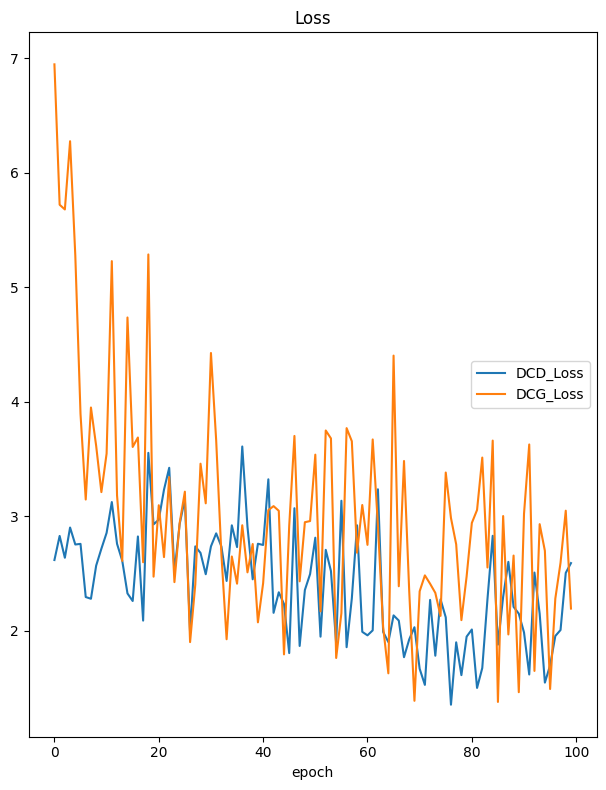

100%|██████████| 100/100 [23:36<00:00, 14.16s/it]

Loss
	DCD_Loss         	 (min:    1.353, max:    3.608, cur:    2.590)
	DCG_Loss         	 (min:    1.377, max:    6.945, cur:    2.192)


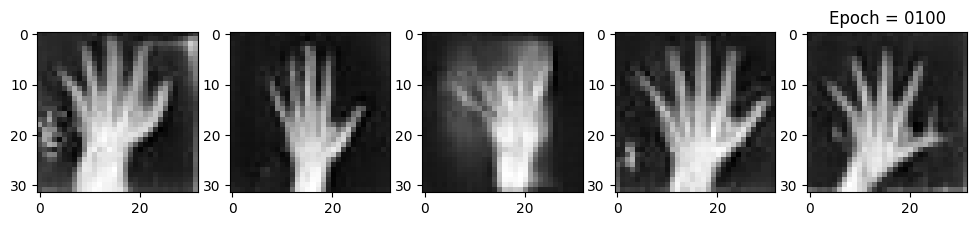

In [ ]:
model_train(n_epochs=100, plot_output=True, )

#### The model looks good, then load the model saved above to train another 100 epochs

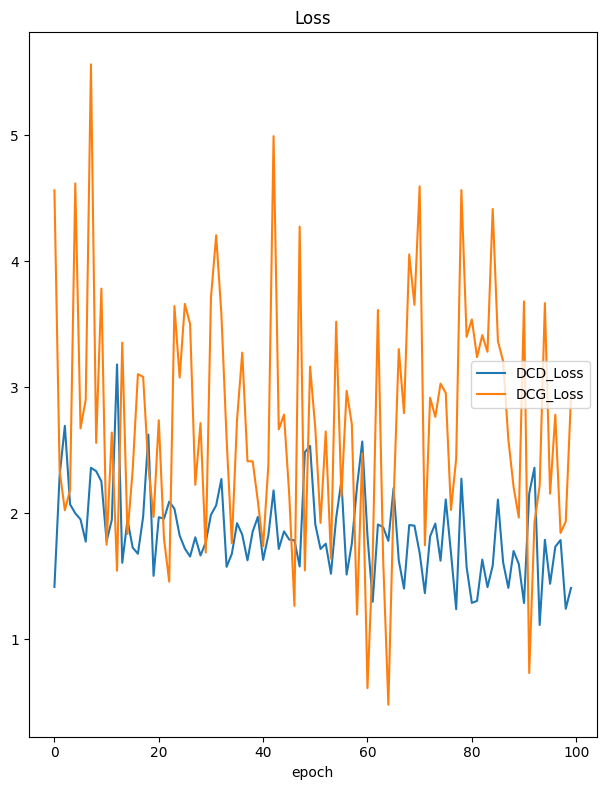

100%|██████████| 100/100 [15:49<00:00,  9.49s/it]

Loss
	DCD_Loss         	 (min:    1.115, max:    3.182, cur:    1.408)
	DCG_Loss         	 (min:    0.482, max:    5.564, cur:    2.923)


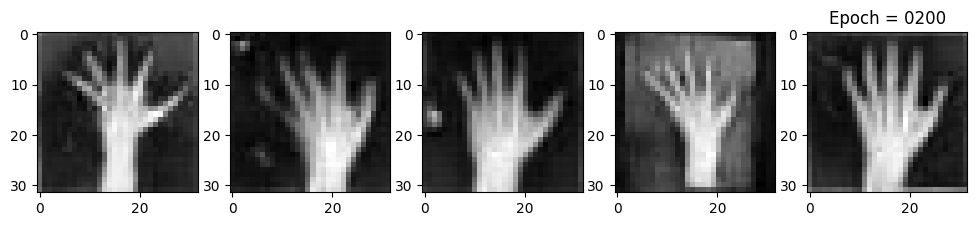

In [ ]:
model_train(n_epochs=200, plot_output=True, load_model=True, epoch_start=100)

## Generate 300 new samples with your trained network

### I would use the model saved in 160 epochs, because you can see 160 epochs has the least losses.

Text(0.5, 1.0, 'Epoch = 0160')

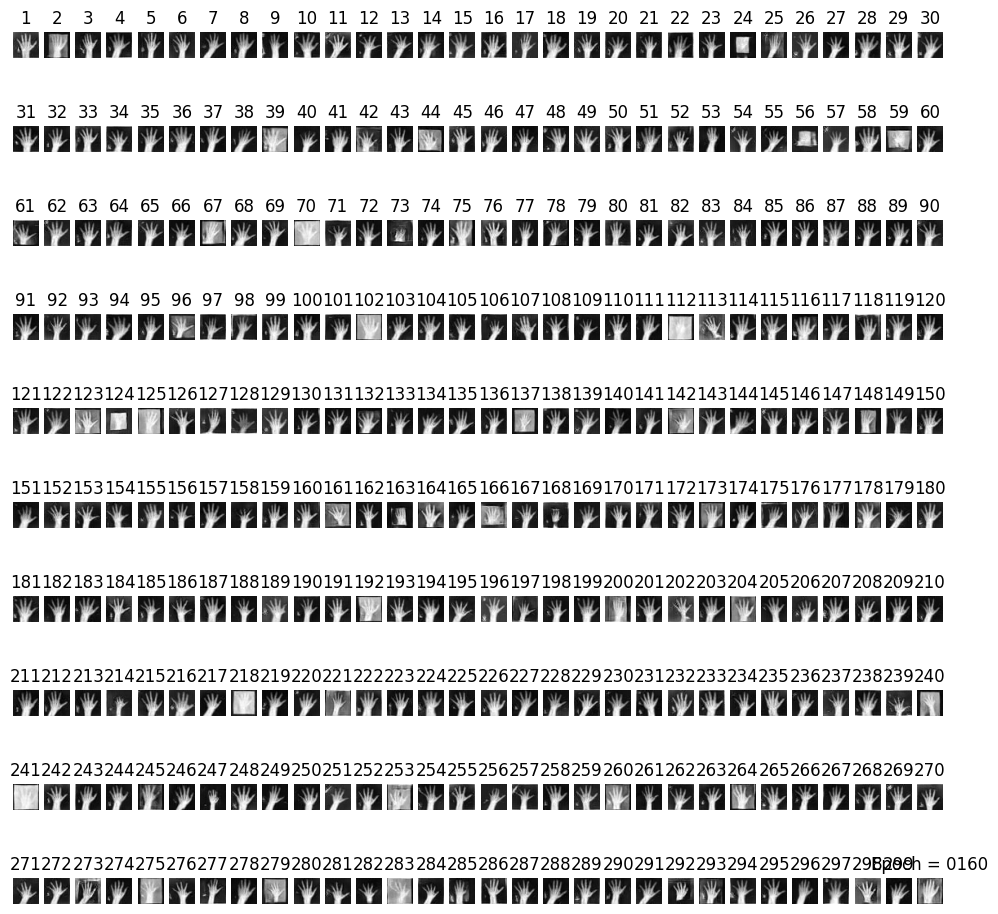

In [107]:
"""visualise the output of the generator"""
from torchvision.utils import save_image
set_seed(0) 

epoch = 160  # load the model from epoch 160
DCG.load_state_dict(torch.load("./models/DCGenerator_{:04d}.pth".format(epoch))) # load the model

with torch.no_grad():
    test_z = torch.randn(300, z_dim).to(device)
    generated = DCG(test_z)

fig, axarr = plt.subplots(10, 30, figsize=(12, 12))
idx = 0
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  idx += 1
  ax.imshow(img, cmap="gray")
  ax.axis('off')
  ax.set_title('{}'.format(idx), loc='center')
  
plt.title('Epoch = {:04d}'.format(epoch), loc='center')

## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

### Run the following cell to save the images output from the generator.

Text(0.5, 1.0, 'Epoch = 0160')

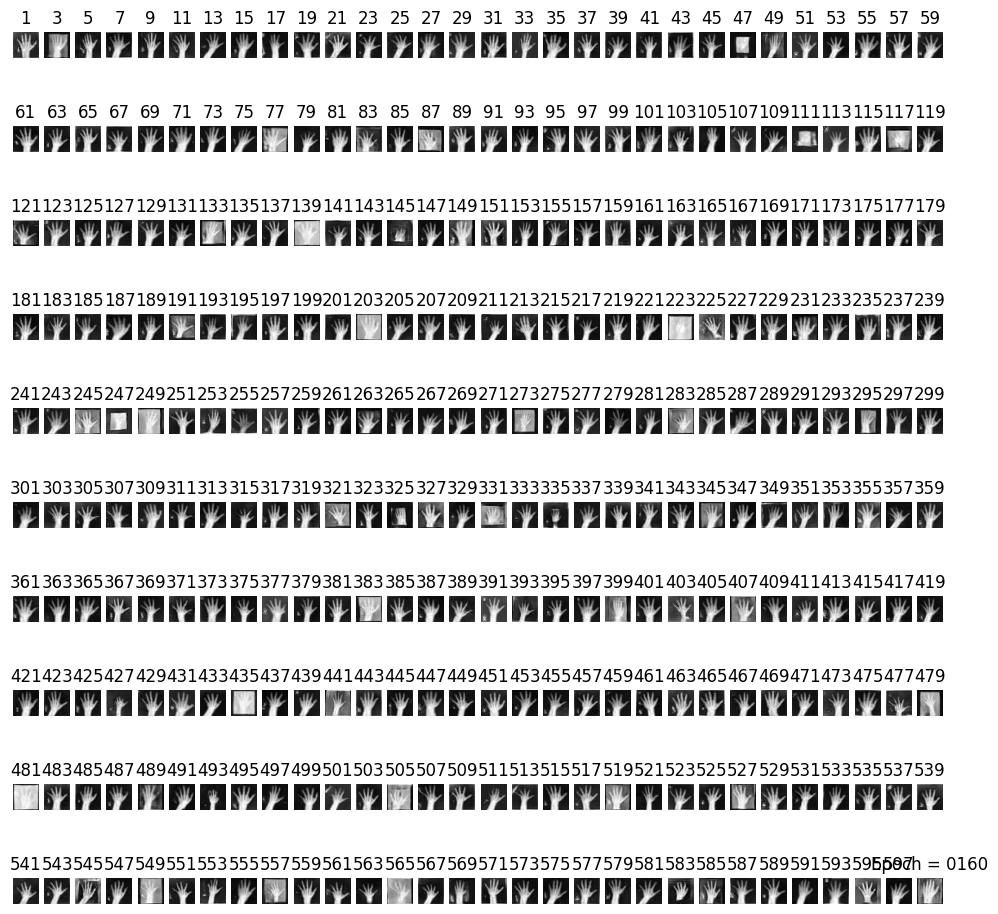

In [106]:
from torchvision.utils import save_image
set_seed(0) 

epoch = 160  ## get the model after 20 epochs and use it:
DCG.load_state_dict(torch.load("./models/DCGenerator_{:04d}.pth".format(epoch)))

with torch.no_grad():
    test_z = torch.randn(300, z_dim).to(device)
    generated = DCG(test_z)
    # save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
fig, axarr = plt.subplots(10, 30, figsize=(12, 12))
idx = 0
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
    idx += 1
    ax.imshow(img, cmap="gray")
    save_image(img, './GAN_hands/acse-xz4019_GAN' + '{:03d}'.format(idx) + '.jpeg')
    ax.axis('off')
    ax.set_title('{}'.format(idx), loc='center')
    idx += 1
plt.title('Epoch = {:04d}'.format(epoch), loc='center')